In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from itertools import product
from transformers import BertTokenizer, AdamW
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from pys.functions import CustomBertModel, create_dataset, train_with_validation
from pys.data import train_df, val_df, filtered_labels_at_least_5_list, combined_df, label_mapping
from pys.params import num_epochs
from bayes_opt import BayesianOptimization
%run decay_grid_search.ipynb

The code currently searches for hyperparameters that maximize the F1 score on the validation set. To also consider the loss and accuracy values, you can either adjust the objective function to incorporate a weighted combination of these values, or switch to a library that supports multi-objective optimization.

In [2]:
param_space = {
    'learning_rate': (1e-6, 1e-3),
    'batch_size': (16, 32)
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
helper = {}

In [4]:
def plot(acc_train, acc_val, f1_train, f1_val, loss_train, loss_val, learning_rate, batch_size):
    
    epochs = range(1, num_epochs + 1)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))  

    axes[0].plot(epochs, acc_train, color='blue', linestyle='-', label='Train Accuracy')
    axes[0].plot(epochs, acc_val, color='red', linestyle='-', label='Validation Accuracy')
    axes[0].set_title('Accuracy Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(epochs, f1_train, color='blue', linestyle='-', label='Train F1 Score')
    axes[1].plot(epochs, f1_val, color='red', linestyle='-', label='Validation F1 Score')
    axes[1].set_title('F1 Score Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(epochs, loss_train, color='blue', linestyle='-', label='Train Loss')
    axes[2].plot(epochs, loss_val, color='red', linestyle='-', label='Validation Loss')
    axes[2].set_title('Loss Over Epochs')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].grid(True)

    fig.suptitle(f"Training and Validation Metrics\n"
                 f"Learning Rate: {learning_rate}, Batch Size: {batch_size}", fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [5]:
def objective(learning_rate, batch_size):
    batch_size = int(round(batch_size))
    
    model = CustomBertModel(num_labels=len(filtered_labels_at_least_5_list))
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    model.to(device)

    train_dataset = create_dataset(train_df, tokenizer, label_mapping)
    val_dataset = create_dataset(val_df, tokenizer, label_mapping)

    train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

    f1_train, f1_val, acc_train, acc_val, loss_train, loss_val, scheduler, scheduler_params = decay_lr_grid(model, train_loader, val_loader, optimizer, device, num_epochs)

    plot(acc_train, acc_val , f1_train, f1_val, loss_train, loss_val, learning_rate, batch_size)

    
    helper[f1_val[-1]] = {
            'name': scheduler.__class__.__name__,
            'params': scheduler_params
        }
    
    return f1_val[-1]

|   iter    |  target   | batch_... | learni... |
-------------------------------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using ExponentialLR with gamma=0.9


Training Epoch 1/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.247573, Accuracy: 14.285714%, F1 Score: 0.098439
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 2/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.288383, Accuracy: 19.047619%, F1 Score: 0.131639
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 3/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.191267, Accuracy: 15.873016%, F1 Score: 0.071024
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 4/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.187773, Accuracy: 14.285714%, F1 Score: 0.070134
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 5/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 2.183861, Accuracy: 14.285714%, F1 Score: 0.082110
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 6/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 2.172590, Accuracy: 6.349206%, F1 Score: 0.039683
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778
Using StepLR with step_size=2 and gamma=0.9


Training Epoch 1/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.174054, Accuracy: 11.111111%, F1 Score: 0.060700
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 2/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.127491, Accuracy: 17.460317%, F1 Score: 0.094350
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 3/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.129442, Accuracy: 17.460317%, F1 Score: 0.123971
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 4/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.096120, Accuracy: 20.634921%, F1 Score: 0.125182
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 5/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 2.124033, Accuracy: 15.873016%, F1 Score: 0.100110
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 6/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 2.172592, Accuracy: 11.111111%, F1 Score: 0.062132
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778
Using MultiStepLR with milestones=[1, 5] and gamma=0.1


Training Epoch 1/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.130188, Accuracy: 12.698413%, F1 Score: 0.087523
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 2/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.154038, Accuracy: 12.698413%, F1 Score: 0.107539
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 3/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.106232, Accuracy: 20.634921%, F1 Score: 0.133554
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 4/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.154514, Accuracy: 11.111111%, F1 Score: 0.050046
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 5/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 2.121789, Accuracy: 14.285714%, F1 Score: 0.087912
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 6/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 2.112731, Accuracy: 15.873016%, F1 Score: 0.093980
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211
Using ReduceLROnPlateau with mode=max, factor=0.1, patience=2


Training Epoch 1/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.111403, Accuracy: 14.285714%, F1 Score: 0.092602
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 2/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.129184, Accuracy: 20.634921%, F1 Score: 0.143288
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 3/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.135267, Accuracy: 17.460317%, F1 Score: 0.143251
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 4/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.168245, Accuracy: 11.111111%, F1 Score: 0.053460
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 5/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 2.084941, Accuracy: 17.460317%, F1 Score: 0.155494
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 6/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 2.149674, Accuracy: 14.285714%, F1 Score: 0.093260
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211
Using CosineAnnealingLR with T_max=50 and eta_min=1e-05


Training Epoch 1/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.135188, Accuracy: 15.873016%, F1 Score: 0.096451
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 2/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.137378, Accuracy: 15.873016%, F1 Score: 0.123234
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 3/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.118463, Accuracy: 14.285714%, F1 Score: 0.102503
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 4/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.136975, Accuracy: 15.873016%, F1 Score: 0.094702
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 5/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 2.136706, Accuracy: 14.285714%, F1 Score: 0.087113
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 6/6:   0%|          | 0/3 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 2.132350, Accuracy: 14.285714%, F1 Score: 0.065671
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


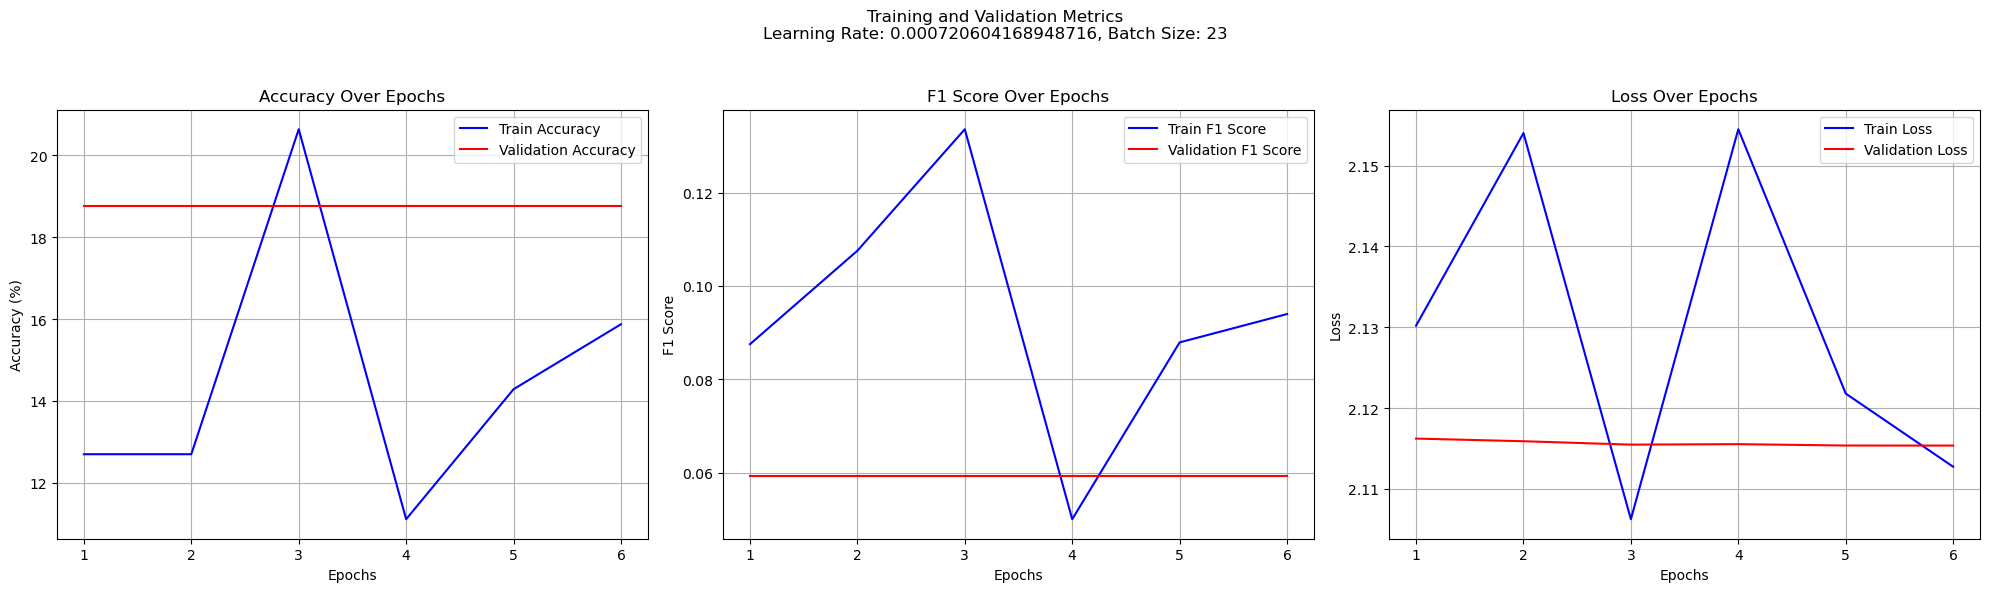

| 1         | 0.05921   | 22.67     | 0.0007206 |


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using ExponentialLR with gamma=0.9


Training Epoch 1/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.244658, Accuracy: 14.285714%, F1 Score: 0.110199
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 2/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.185859, Accuracy: 11.111111%, F1 Score: 0.077563
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 3/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.145366, Accuracy: 9.523810%, F1 Score: 0.048677
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 4/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.138171, Accuracy: 15.873016%, F1 Score: 0.086701
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 5/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 2.123573, Accuracy: 14.285714%, F1 Score: 0.082636
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 6/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 2.154767, Accuracy: 23.809524%, F1 Score: 0.157039
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778
Using StepLR with step_size=2 and gamma=0.9


Training Epoch 1/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.165306, Accuracy: 19.047619%, F1 Score: 0.082463
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 2/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.136824, Accuracy: 19.047619%, F1 Score: 0.111547
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 3/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.147542, Accuracy: 14.285714%, F1 Score: 0.074626
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 4/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.140455, Accuracy: 15.873016%, F1 Score: 0.103618
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 5/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 2.149035, Accuracy: 11.111111%, F1 Score: 0.057791
Validation Accuracy: 18.750000%, Validation F1 Score: 0.059211


Training Epoch 6/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 2.104674, Accuracy: 15.873016%, F1 Score: 0.122983
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778
Using MultiStepLR with milestones=[1, 5] and gamma=0.1


Training Epoch 1/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.141677, Accuracy: 17.460317%, F1 Score: 0.118619
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 2/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.121524, Accuracy: 19.047619%, F1 Score: 0.108000
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 3/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.103658, Accuracy: 19.047619%, F1 Score: 0.127135
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 4/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.102645, Accuracy: 12.698413%, F1 Score: 0.082630
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 5/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 2.094378, Accuracy: 23.809524%, F1 Score: 0.158185
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 6/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 2.093521, Accuracy: 19.047619%, F1 Score: 0.126332
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778
Using ReduceLROnPlateau with mode=max, factor=0.1, patience=2


Training Epoch 1/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.118760, Accuracy: 15.873016%, F1 Score: 0.126766
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 2/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.112660, Accuracy: 20.634921%, F1 Score: 0.138220
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 3/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.123953, Accuracy: 17.460317%, F1 Score: 0.129852
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 4/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.143597, Accuracy: 11.111111%, F1 Score: 0.057937
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 5/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 2.131130, Accuracy: 17.460317%, F1 Score: 0.112164
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 6/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 2.160407, Accuracy: 9.523810%, F1 Score: 0.044580
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778
Using CosineAnnealingLR with T_max=50 and eta_min=1e-05


Training Epoch 1/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.079019, Accuracy: 19.047619%, F1 Score: 0.137352
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 2/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.055189, Accuracy: 28.571429%, F1 Score: 0.212398
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 3/6:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
optimizer = BayesianOptimization(
    f=objective,
    pbounds=param_space,
    random_state=1,
)


optimizer.maximize( ############################################################################################
    init_points=2, 
    n_iter=5,       
)

print("Best result found:")
print(optimizer.max)

f1_scores = []

for res in optimizer.res:
    f1_scores.append(res['target']) 

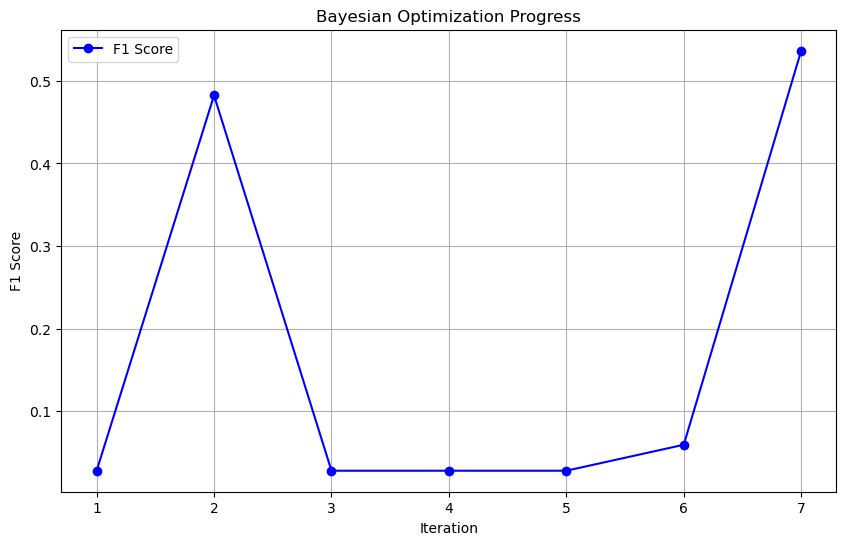

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o', color='b', label='F1 Score')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('Bayesian Optimization Progress')
plt.legend()
plt.grid(True)
plt.show()

print(helper)